## 0. 모듈 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

import pickle
import cv2
#import mediapipe as mp

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow import keras

from keras.callbacks import ModelCheckpoint

from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D,\
                        Permute, TimeDistributed, Bidirectional,GRU, LeakyReLU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Reshape
from keras import models
from keras import layers
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input #InceptionV3, Xception, InceptionResNetV2
#from keras.applications.imagenet_utils import preprocess_input #others
from sklearn.model_selection import train_test_split

In [ ]:
directory='/content/drive/MyDrive/data/KSL_rgb (1)'

In [ ]:
#한 폴더당 중심 동작 20개씩 뽑음
select_df=pd.read_csv('/content/drive/MyDrive/data/DF_select.csv')

In [ ]:
select_df['path']=directory+'/'+select_df['fold']+'/'+select_df['name']
select_df

,name,fold,class,num,path,label
0,00_01.0045.jpg,00_01,1,45,/content/drive/MyDrive/data/KSL_rgb (1)/00_01/...,hi
1,00_01.0046.jpg,00_01,1,46,/content/drive/MyDrive/data/KSL_rgb (1)/00_01/...,hi
2,00_01.0047.jpg,00_01,1,47,/content/drive/MyDrive/data/KSL_rgb (1)/00_01/...,hi
3,00_01.0048.jpg,00_01,1,48,/content/drive/MyDrive/data/KSL_rgb (1)/00_01/...,hi
4,00_01.0049.jpg,00_01,1,49,/content/drive/MyDrive/data/KSL_rgb (1)/00_01/...,hi
...,...,...,...,...,...,...
3595,19_77.0072.jpg,19_77,77,72,/content/drive/MyDrive/data/KSL_rgb (1)/19_77/...,care
3596,19_77.0073.jpg,19_77,77,73,/content/drive/MyDrive/data/KSL_rgb (1)/19_77/...,care
3597,19_77.0074.jpg,19_77,77,74,/content/drive/MyDrive/data/KSL_rgb (1)/19_77/...,care
3598,19_77.0075.jpg,19_77,77,75,/content/drive/MyDrive/data/KSL_rgb (1)/19_77/...,care


## 4. 최종 예측
- inception_v3에 대해 전이학습

train, test 분리

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(select_df, select_df['label'], test_size=0.25, random_state=2020)

train, valid 분리 및 데이터 불러오기

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/ 255, validation_split=0.25)
test_datagen = ImageDataGenerator(rescale=1/ 255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
          dataframe=x_train,
          batch_size=64,
          class_mode='categorical',
          shuffle=True,
          seed=2022,
          x_col='path',
          y_col='label',
          subset = 'training',)

valid_generator = train_datagen.flow_from_dataframe(
          dataframe=x_train,
          batch_size=64,
          class_mode='categorical',
          shuffle=True,
          seed=2022,
          x_col='path',
          y_col='label',
          subset = 'validation')

test_generator = test_datagen.flow_from_dataframe(
          dataframe=x_test,
          batch_size=64,
          class_mode='categorical',
          x_col='path',
          y_col='label')

Found 2025 validated image filenames belonging to 10 classes.
Found 675 validated image filenames belonging to 10 classes.
Found 900 validated image filenames belonging to 10 classes.


- training dataset : 2025
- validation dataset : 675
- test dataset : 900

모델링

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
  -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-12-05 07:08:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  17.9MB/s    in 5.7s    

2022-12-05 07:08:42 (14.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(256, 256, 3),
                              include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_618 (Conv2D)            (None, 127, 127, 32  864         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_620 (Batch  (None, 127, 127, 32  96         ['conv2d_618[0][0]']             
 Normalization)                 )                                                      

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/checkpoint/best_trn.ckpt'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

학습

In [ ]:
history = model.fit(
  train_generator,
  validation_data=valid_generator,
  steps_per_epoch=20,
  epochs=30,
  validation_steps=10,
  verbose=1,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 6.6167 - accuracy: 0.4097
Epoch 1: val_accuracy improved from -inf to 0.67969, saving model to /content/drive/MyDrive/checkpoint/best_trn.ckpt
20/20 [==============================] - 18s 778ms/step - loss: 6.6167 - accuracy: 0.4097 - val_loss: 1.0954 - val_accuracy: 0.6797
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8592
Epoch 2: val_accuracy improved from 0.67969 to 0.95312, saving model to /content/drive/MyDrive/checkpoint/best_trn.ckpt
20/20 [==============================] - 12s 607ms/step - loss: 0.4806 - accuracy: 0.8592 - val_loss: 0.2078 - val_accuracy: 0.9531
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9849
Epoch 3: val_accuracy improved from 0.95312 to 0.98594, saving model to /content/drive/MyDrive/checkpoint/best_trn.ckpt
20/20 [==============================] - 12s 615ms/step - loss: 0.0929 - accuracy: 0.9849 - val_l

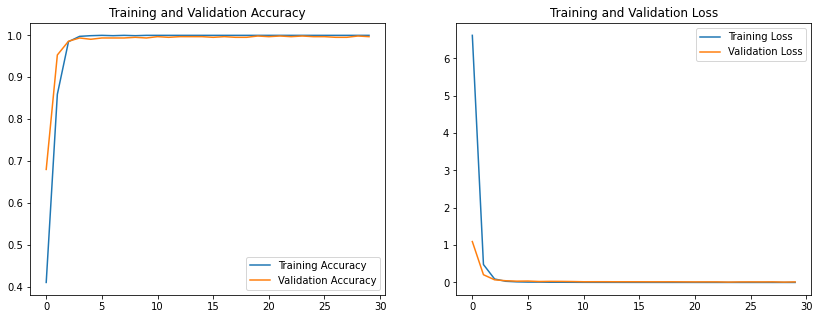

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

- loss값도 학습이 진행될수록 감소하는 추세
- 최고 val_accuracy는 0.9984

test로 최종 평가

In [ ]:
model.load_weights('/content/drive/MyDrive/checkpoint/best_trn.ckpt')

In [ ]:
model.evaluate(test_generator)

15/15 [==============================] - 4s 267ms/step - loss: 0.0160 - accuracy: 0.9967


[0.015990806743502617, 0.996666669845581]